Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /Users/tskz48/Library/Mobile Documents/com~apple~CloudDocs/QMMLKaggleCompetitions/ComputerVision
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.2)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.02, 0.02))
               GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


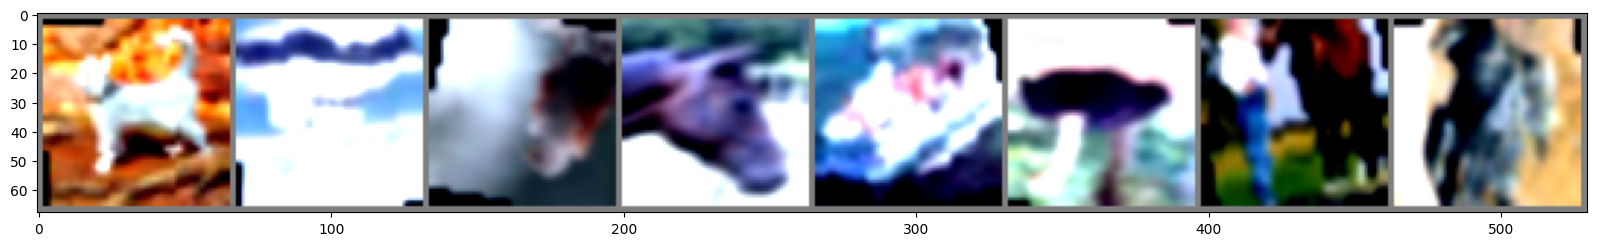

cat                 ship                bird                horse               ship                bird                horse               frog                
Using device: cuda


<ipython-input-4-8b176c6f6ec6>:162: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-4-8b176c6f6ec6>:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-4-8b176c6f6ec6>:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/100], Loss: 1164.1774, Accuracy: 45.7460


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-4-8b176c6f6ec6>:195: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [2/100], Loss: 859.6174, Accuracy: 60.8200
Epoch [3/100], Loss: 727.1376, Accuracy: 67.3500
Epoch [4/100], Loss: 644.8229, Accuracy: 71.0940
Epoch [5/100], Loss: 591.6640, Accuracy: 73.6600


In [ ]:

import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

#A residual neural network for image classification of the CIFAR10 dataset.
# # Load an image
# image_path = "images/img1.jpg"
# image = Image.open(image_path).convert("RGB")
#transforms.ToPILImage()



# Data augmentation pipeline.
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip horizontally
    transforms.RandomVerticalFlip(p=0.2),    # 20% chance to flip vertically
    transforms.RandomRotation(degrees=15),   # Rotate image between -15° and 15°
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.8, 1.0)),  # Crop and resize
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.02), # Adjust colors
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply slight blur
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


train_dataset = datasets.CIFAR10(root="/Users/tskz48/Library/Mobile Documents/com~apple~CloudDocs/QMMLKaggleCompetitions/ComputerVision", train=True, transform=data_transforms, download=True)
val_dataset = datasets.CIFAR10(root="/Users/tskz48/Library/Mobile Documents/com~apple~CloudDocs/QMMLKaggleCompetitions/ComputerVision", train=False, transform=data_transforms, download=True)

print(train_dataset)

train_classes_items = dict()

for train_item in train_dataset:
    label = train_dataset.classes[train_item[1]]
    if label not in train_classes_items:
        train_classes_items[label] = 1
    else:
        train_classes_items[label] += 1

train_classes_items  #counts how many time each class label appears, by iterating through the training dataset.


train_8_samples = DataLoader(train_dataset, batch_size=8, num_workers=4, pin_memory=True, shuffle=True)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize. #we need to reverse normalisation to bring the pixels back to their original range, for visualisation, so the images appear normal.
    npimg = img.numpy() #converts tensor to numpy array, since matplotlib can't handle pytorch tensors directly.
    plt.figure(figsize = (20,20))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_8_samples)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print(''.join(f'{train_dataset.classes[labels[j]]:20s}' for j in range(8)))




# train_dataset = datasets.ImageFolder(root="dataset/train", transform=data_transforms)
# val_dataset = datasets.ImageFolder(root="dataset/val", transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)


    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)


    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1)) #Global Average Pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



def ResNet18(num_classes=10): #ResNet18 has 18 fundamental layers in total.
    layers=[2, 2, 2, 2]
    model= ResNet(ResidualBlock,layers,num_classes=num_classes)

    return model




# Initialize model

torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision('high')
scaler = torch.cuda.amp.GradScaler()
num_classes = 10
model = ResNet18(num_classes)
model = torch.compile(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training loop


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU
model.to(device)

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)


        #bbox_pred,
        with torch.cuda.amp.autocast():
          class_pred = model(images)

        #loss_bbox = criterion(bbox_pred, targets["boxes"])
          loss_class = criterion(class_pred, targets)


        optimizer.zero_grad()
        scaler.scale(loss_class).backward()
        scaler.step(optimizer)
        scaler.update()

        #loss = loss_bbox + loss_class

        # loss_class.backward()
        # optimizer.step()

        total_loss += loss_class.item()

        _, predicted = torch.max(class_pred, 1) #Find the maximum value and predicted classes along the first dimension.

        # Update the running total of correct predictions and samples
        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        accuracy = 100 * (total_correct / total_samples)


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")
    torch.cuda.empty_cache()



